In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
from datasets import load_from_disk
import torch.nn as nn, torch.nn.functional as F
import torch, json
from transformers import BertTokenizer, BertModel
from utils import BertModel as MedBertModel
from utils import LangCellDataCollatorForCellClassification as DataCollatorForCellClassification
from tqdm import tqdm
from torch.utils.data import DataLoader

class Pooler(nn.Module):
    def __init__(self, config, pretrained_proj, proj_dim):
        super().__init__()
        self.proj = nn.Linear(config.hidden_size, proj_dim)
        self.proj.load_state_dict(torch.load(pretrained_proj))
    def forward(self, hidden_states: torch.Tensor) -> torch.Tensor:
        pooled_output = hidden_states[:, 0]
        pooled_output = F.normalize(self.proj(pooled_output), dim=-1)
        return pooled_output
    
model = BertModel.from_pretrained('ckpt/cell_bert')
model.pooler = Pooler(model.config, pretrained_proj='ckpt/cell_proj.bin', proj_dim=256)
proj = model.pooler.proj
# model = model.module
model = model.to("cuda")

text_pretrained_model = 'microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext'
tokenizer = BertTokenizer.from_pretrained(text_pretrained_model)
tokenizer.add_special_tokens({'bos_token':'[DEC]'})
tokenizer.add_special_tokens({'additional_special_tokens':['[ENC]']})       
tokenizer.enc_token_id = tokenizer.additional_special_tokens_ids[0]  
text_encoder = MedBertModel.from_pretrained('ckpt/text_bert', add_pooling_layer=True)
text_encoder.pooler = Pooler(text_encoder.config, pretrained_proj='ckpt/text_proj.bin', proj_dim=256)
text_encoder = text_encoder.to("cuda")

ctm_head = nn.Linear(text_encoder.config.hidden_size, 2)
ctm_head.load_state_dict(torch.load('ckpt/ctm_head.bin'))
ctm_head = ctm_head.to("cuda")

Some weights of BertModel were not initialized from the model checkpoint at ckpt/cell_bert and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [2]:
def text_encode(text):
    text = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors='pt').to('cuda')
    text = text_encoder(**text).pooler_output
    # text = F.normalize(model.text_projector(text))
    return text

def cell_encode(cell_input_ids, cell_atts):
    cell = model(cell_input_ids.to("cuda"), cell_atts.to("cuda"))
    cell_last_h = cell.last_hidden_state
    cell_pooler = cell.pooler_output
    return cell_last_h, cell_pooler

def ctm(text, cell_emb, cell_atts):
    text = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors='pt').to('cuda')
    output = text_encoder(**text,
                encoder_hidden_states = cell_emb.to("cuda"),
                encoder_attention_mask = cell_atts.to("cuda"),
                return_dict = True,
                mode = 'multimodal',
                )
    logits = ctm_head(output.last_hidden_state[:, 0, :])
    logits = F.softmax(logits, dim=-1)[..., 1] # [n]
    return logits

In [3]:
dataset = load_from_disk("data/pbmc10k.dataset")
dataset_sub = dataset.shuffle(seed=42)#.select(range(1000))
for label_name in ["celltype", "cell_type", "str_labels", "labels"]:
    if label_name in dataset_sub.column_names:
        break
if label_name != "celltype":
    dataset_sub = dataset_sub.rename_column(label_name,"celltype")

In [4]:
print(set(dataset_sub['celltype']))

{'B cells', 'CD8 T cells', 'CD14+ Monocytes', 'Dendritic Cells', 'NK cells', 'Megakaryocytes', 'FCGR3A+ Monocytes', 'CD4 T cells'}


In [11]:
import json
types = list(set(dataset_sub['celltype']))
type2text = json.load(open('data/type2text.json'))
texts = [type2text[typename] for typename in types]
with torch.no_grad():
    text_embs = torch.cat([text_encode(text) for text in texts], 0).T.cuda() # 256 * N
text_embs.requires_grad = False
type2num = dict([(type, i) for i, type in enumerate(types)])

In [12]:
def classes_to_ids(example):
    example["label"] = type2num[example["celltype"]]
    return example
testdataset = dataset_sub.map(classes_to_ids, num_proc=16)
remove_columns = testdataset.column_names
remove_columns.remove('input_ids')
remove_columns.remove('label')
testdataset = testdataset.remove_columns(remove_columns)
batchsize = 32
collator = DataCollatorForCellClassification()
dataloader = DataLoader(testdataset, batch_size=batchsize, collate_fn=collator, shuffle=False)

In [13]:
cell_embs = torch.zeros(len(dataset_sub), 256)
model.eval()
text_encoder.eval()
preds = torch.zeros(len(dataset_sub))
sim_logits = torch.zeros(len(dataset_sub), text_embs.shape[-1])
ctm_logits = torch.zeros(len(dataset_sub), text_embs.shape[-1])
logits = torch.zeros(len(dataset_sub), text_embs.shape[-1])
labels = torch.tensor(testdataset['label'])
with torch.no_grad():
    for i, d in tqdm(enumerate(dataloader)):
        cell_last_h, cellemb = cell_encode(d['input_ids'], d['attention_mask']) # batchsize * 256
        sim = (cellemb @ text_embs) / 0.05 # batchsize * 161
        sim_logit = F.softmax(sim, dim=-1)

        # ctm
        ctm_logit = torch.zeros_like(sim_logit)
        for text_idx, text in enumerate(texts):
            text_list = [text] * sim_logit.shape[0]
            ctm_logit[:, text_idx] = ctm(text_list, cell_last_h, d['attention_mask'])
        ctm_logit = F.softmax(ctm_logit, dim=-1)

        logit = (sim_logit + ctm_logit) / 2
        pred = logit.argmax(dim=-1)
        sim_logits[i * batchsize: (i + 1) * batchsize] = sim_logit.cpu()
        ctm_logits[i * batchsize: (i + 1) * batchsize] = ctm_logit.cpu()
        logits[i * batchsize: (i + 1) * batchsize] = logit.cpu()
        cell_embs[i * batchsize: (i + 1) * batchsize] = cellemb.cpu()
        preds[i * batchsize: (i + 1) * batchsize] = pred.cpu()

# torch.save({'cell_embs': cell_embs,
#             'sim_logits': sim_logits, 'ctm_logits': ctm_logits, 
#             'preds': preds, 'labels': labels, 'logits': logits}, 
#            'data/results.pt')

0it [00:00, ?it/s]

361it [24:49,  4.12s/it]


In [15]:

# %%
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, average_precision_score
import numpy as np
sim_preds = sim_logits.argmax(dim=-1)
ctm_preds = ctm_logits.argmax(dim=-1)
alpha = 0.1
preds = (alpha * sim_logits + (1 - alpha) * ctm_logits).argmax(dim=-1)
labels = torch.tensor(testdataset['label'])
for row in confusion_matrix(labels, preds):
    print('\t'.join([str(x) for x in row]))
print(classification_report(labels, preds, digits=4))

1587	1	3	1	19	3	0	7
0	1339	0	0	34	0	0	75
2	4	2203	2	2	6	3	5
0	2	34	220	2	81	0	0
0	5	0	0	444	5	0	3
0	1	11	0	1	75	0	0
0	0	28	1	21	7	293	1
1	663	3	0	3	0	0	4326
              precision    recall  f1-score   support

           0     0.9981    0.9790    0.9885      1621
           1     0.6645    0.9247    0.7733      1448
           2     0.9654    0.9892    0.9772      2227
           3     0.9821    0.6490    0.7815       339
           4     0.8441    0.9716    0.9034       457
           5     0.4237    0.8523    0.5660        88
           6     0.9899    0.8348    0.9057       351
           7     0.9794    0.8659    0.9192      4996

    accuracy                         0.9098     11527
   macro avg     0.8559    0.8833    0.8518     11527
weighted avg     0.9306    0.9098    0.9140     11527



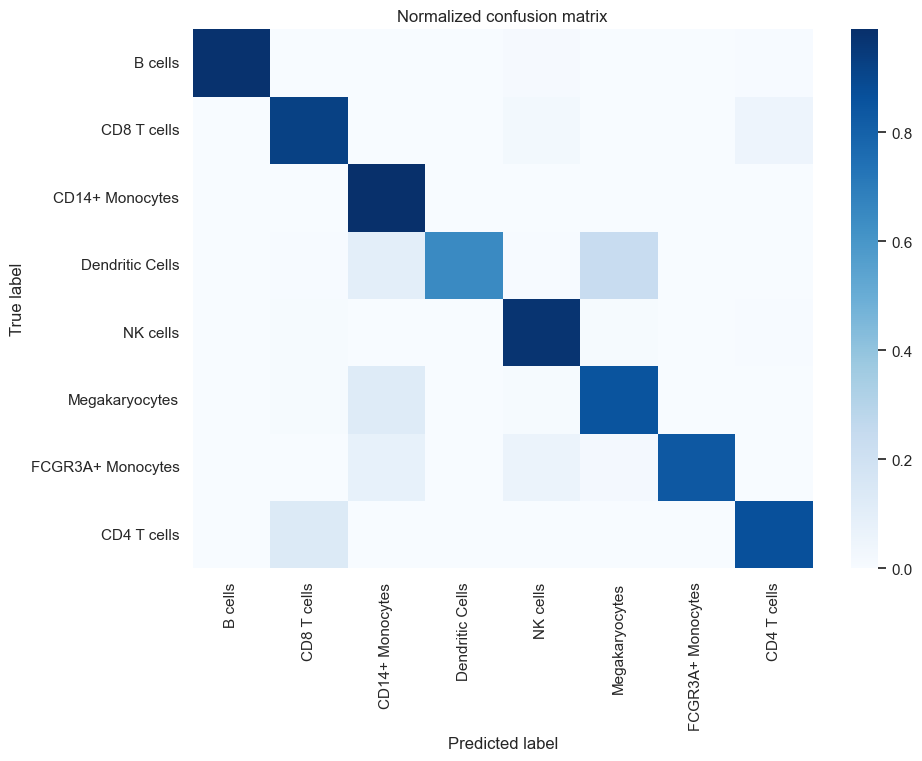

In [19]:
# heatmap
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    df_cm = pd.DataFrame(cm, index=classes, columns=classes)
    plt.figure(figsize=(10, 7))
    sns.heatmap(df_cm, annot=False, cmap=cmap)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

plot_confusion_matrix(labels, preds, types, normalize=True)

In [ ]:
import anndata as ad, scanpy as sc
cell_embs_ad = ad.AnnData(cell_embs.numpy())
cell_embs_ad.obs['celltype'] = dataset_sub['celltype']
if 'batch' in dataset_sub.features.keys():
    cell_embs_ad.obs['batch'] = dataset_sub['batch']
    cell_embs_ad.obs['batch'] = cell_embs_ad.obs['batch'].astype(str)
cell_embs_ad.obs['predictions'] = [types[i] for i in preds]
sc.pp.neighbors(cell_embs_ad, use_rep='X', n_neighbors=80)


/mnt/users/zhaosy/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/mnt/users/zhaosy/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/mnt/users/zhaosy/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


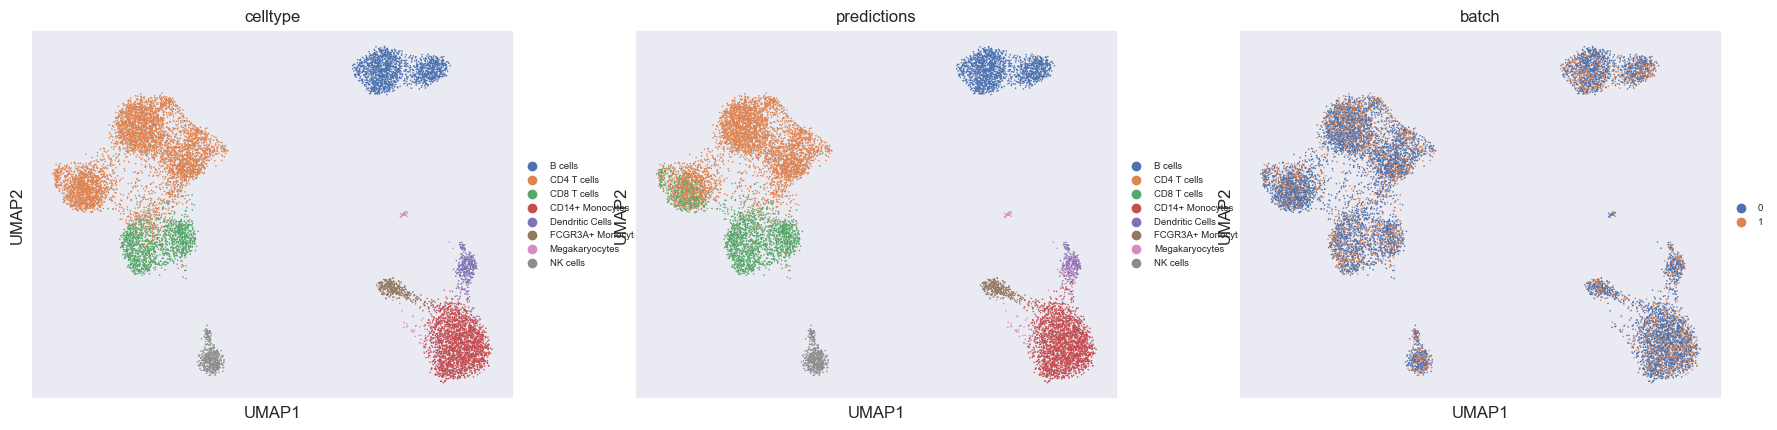

In [26]:
sc.tl.umap(cell_embs_ad)
sc.pl.umap(cell_embs_ad, color=['celltype', 'predictions', 'batch'],legend_fontsize ='xx-small',size=5,legend_fontweight='light')

It is evident that the cell embeddings generated directly by LangCell, without any fine-tuning, possess desirable properties: they cluster by cell type and eliminate batch effects. By comparing the left and middle plots, one can intuitively observe that LangCell is capable of reliably annotating cell types in a zero-shot scenario.
